In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

## Data

In [2]:
dataset = pd.read_csv('data_log.csv')
train_dataset = dataset.sample(frac=0.8, random_state=0xe621)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('total_tweets')
train_db = train_dataset.pop('db')
test_labels = test_dataset.pop('total_tweets')
test_db = test_dataset.pop('db')

In [3]:
train_stats = train_dataset.describe().transpose()
train_labels_stats = train_labels.describe().transpose()
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def denorm(z):
    return z * train_labels_stats['std'] + train_labels_stats['mean']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Graphs

In [4]:
def plot_prediction(test_labels, test_predictions):
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values [log(x)]')
    plt.ylabel('Predictions [log(x)]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-5, 5], [-5, 5])

In [5]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    #   plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    #   plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label='Val Loss')
    plt.legend()

    plt.show()

## Neural Network

In [6]:
def build_model(hidden_layers):
    layers = [
        tf.keras.layers.Dense(41, activation='relu', input_shape=[len(train_dataset.keys())])
    ]
    
    for layer_config in hidden_layers:
        if len(layer_config) == 1:
            size, activation = layer_config[0], 'relu'
        else:
            size, activation = layer_config
        
        layers.append(tf.keras.layers.Dense(size, activation=activation))
    
    layers.append(tf.keras.layers.Dense(1))
    
    model = tf.keras.Sequential(layers)

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae', 'mse']
    )
    
    return model

In [7]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

### 82 on the hidden

In [8]:
nnr_82 = build_model([ (82, 'relu') ])

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_82.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.................................................................................................

### 41 on the hidden

In [9]:
nnr_41 = build_model([ (41, 'relu') ])

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_41.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.............................................

### 20 on the hidden

In [10]:
nnr_20 = build_model([ (20, 'relu') ])

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_20.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................
....................

### 41, 20 on the hidden

In [11]:
nnr_41_20 = build_model([ (41,), (20,) ])

EPOCHS = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = nnr_41_20.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


....................................................................................................
...............................

## Regression Tree

In [12]:
tr = DecisionTreeRegressor(criterion='mae')

In [13]:
tr = tr.fit(normed_train_data, train_labels)

## Support Vector Regression

In [14]:
svr = SVR(gamma='scale')

In [15]:
svr = svr.fit(normed_train_data, train_labels)

## Results

In [16]:
predicts = {
    'nnr_82_test': nnr_82.predict(normed_test_data),
    'nnr_82_train': nnr_82.predict(normed_train_data),
    'nnr_41_test': nnr_41.predict(normed_test_data),
    'nnr_41_train': nnr_41.predict(normed_train_data),
    'nnr_20_test': nnr_20.predict(normed_test_data),
    'nnr_20_train': nnr_20.predict(normed_train_data),
    'nnr_41_20_test': nnr_41_20.predict(normed_test_data),
    'nnr_41_20_train': nnr_41_20.predict(normed_train_data),
    'tr_test': tr.predict(normed_test_data),
    'tr_train': tr.predict(normed_train_data),
    'svr_test': svr.predict(normed_test_data),
    'svr_train': svr.predict(normed_train_data),
}

labels = {
    'test': test_labels,
    'train': train_labels,
}

In [17]:
data = []
for c in [ 'nnr_82', 'nnr_41', 'nnr_20', 'nnr_41_20', 'tr', 'svr' ]:
    d = { 'config': c }
    for g in [ 'test', 'train' ]:
        k = '{}_{}'.format(c, g)
        d['{}_mse'.format(g)] = sklearn.metrics.mean_squared_error(labels[g], predicts[k])
        d['{}_mae'.format(g)] = sklearn.metrics.mean_absolute_error(labels[g], predicts[k])
        d['{}_r2'.format(g)] = sklearn.metrics.r2_score(labels[g], predicts[k])
        
    data.append(d)

In [18]:
results = pd.DataFrame(data)
results.to_csv('results_3.csv', index=False)
results

,config,test_mse,test_mae,test_r2,train_mse,train_mae,train_r2
0,nnr_82,0.757745,0.751277,-1.709612,0.225982,0.292048,-0.104827
1,nnr_41,0.608807,0.649017,-1.177026,0.522286,0.512916,-1.553460
2,nnr_20,1.942309,1.117181,-5.945486,0.464085,0.359466,-1.268916
3,nnr_41_20,0.756386,0.673649,-1.704753,0.334117,0.325206,-0.633499
4,tr,0.013861,0.101407,0.950435,0.000000,0.000000,1.000000
5,svr,0.076976,0.261775,0.724742,0.008089,0.085651,0.960454


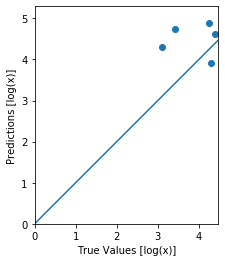

In [19]:
plot_prediction(labels['test'], predicts['nnr_82_test'])
# plot_prediction(labels['train'], predicts['nnr_82_train'])

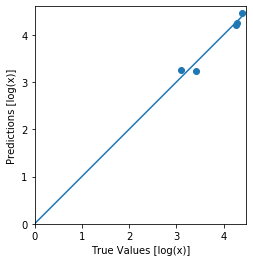

In [20]:
plot_prediction(labels['test'], predicts['tr_test'])
# plot_prediction(labels['train'], predicts['tr_train'])

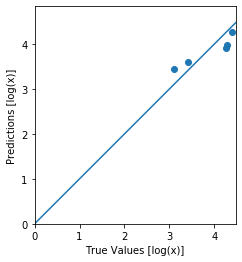

In [21]:
plot_prediction(labels['test'], predicts['svr_test'])
# plot_prediction(labels['train'], predicts['svr_train'])